<a href="https://colab.research.google.com/github/htrisal/DATA603Project1/blob/main/Fake_News_Title_Reading_(Kaggle_Data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [ ]:
true = pd.read_excel('/content/drive/My Drive/Colab Notebooks/True Small.xlsx')
false = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Fake Small.xlsx')

In [ ]:
true

title  ... Category
0   As U.S. budget fight looms, Republicans flip t...  ...        T
1   U.S. military to accept transgender recruits o...  ...        T
2   Senior U.S. Republican senator: 'Let Mr. Muell...  ...        T
3   FBI Russia probe helped by Australian diplomat...  ...        T
4   Trump wants Postal Service to charge 'much mor...  ...        T
..                                                ...  ...      ...
94  House plan would increase Trump's disaster aid...  ...        T
95  House panel chair introduces $81 billion disas...  ...        T
96  Trump nominates Liberty University professor t...  ...        T
97  Trump on Twitter (Dec 18) - Congressional Race...  ...        T
98  Trump Cabinet officials to visit Puerto Rico t...  ...        T

[99 rows x 5 columns]

In [ ]:
false

title  ... Category
0    Donald Trump Sends Out Embarrassing New Year’...  ...        F
1    Drunk Bragging Trump Staffer Started Russian ...  ...        F
2    Sheriff David Clarke Becomes An Internet Joke...  ...        F
3    Trump Is So Obsessed He Even Has Obama’s Name...  ...        F
4    Pope Francis Just Called Out Donald Trump Dur...  ...        F
..                                                ...  ...      ...
94   WATCH: Delusional Trump Fans Lash Out At Fox ...  ...        F
95   Roy Moore Supporting Republican LOSES It Afte...  ...        F
96   That Story Trump Just Told The Press About Ob...  ...        F
97  This 4-Year Old Tweet From Donald Trump Shows ...  ...        F
98   OOPS: Trump Judicial Nominee Didn’t Tell Cong...  ...        F

[99 rows x 5 columns]

In [ ]:
nltk.download('stopwords')

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
true['title']=true['title'].apply(denoise_text)
false['title']=false['title'].apply(denoise_text)

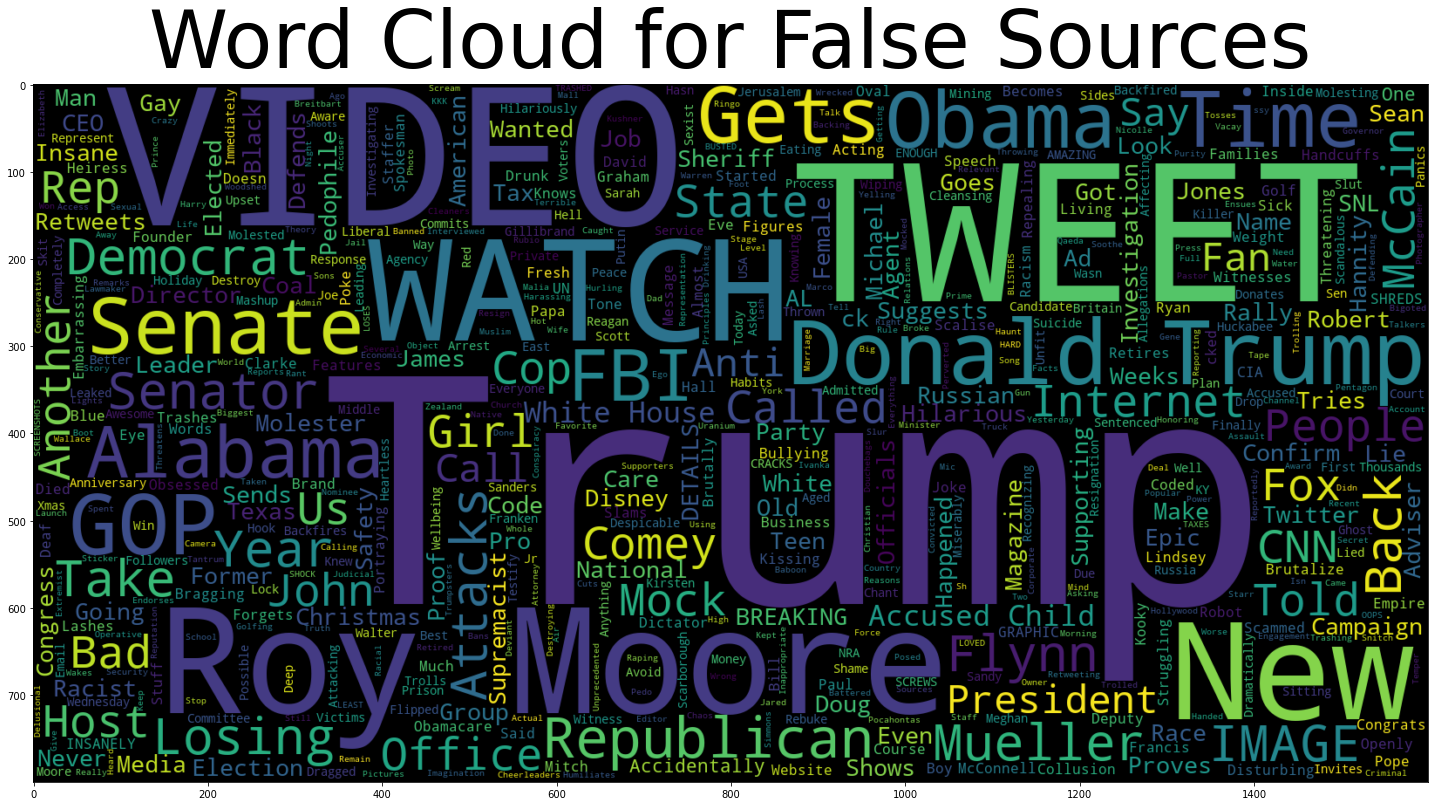

In [ ]:
plt.figure(figsize = (25,25)) # Text that is not Fake
plt.title('Word Cloud for False Sources',fontsize=80)
wc_false = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(false['title']))
plt.imshow(wc_false , interpolation = 'bilinear')

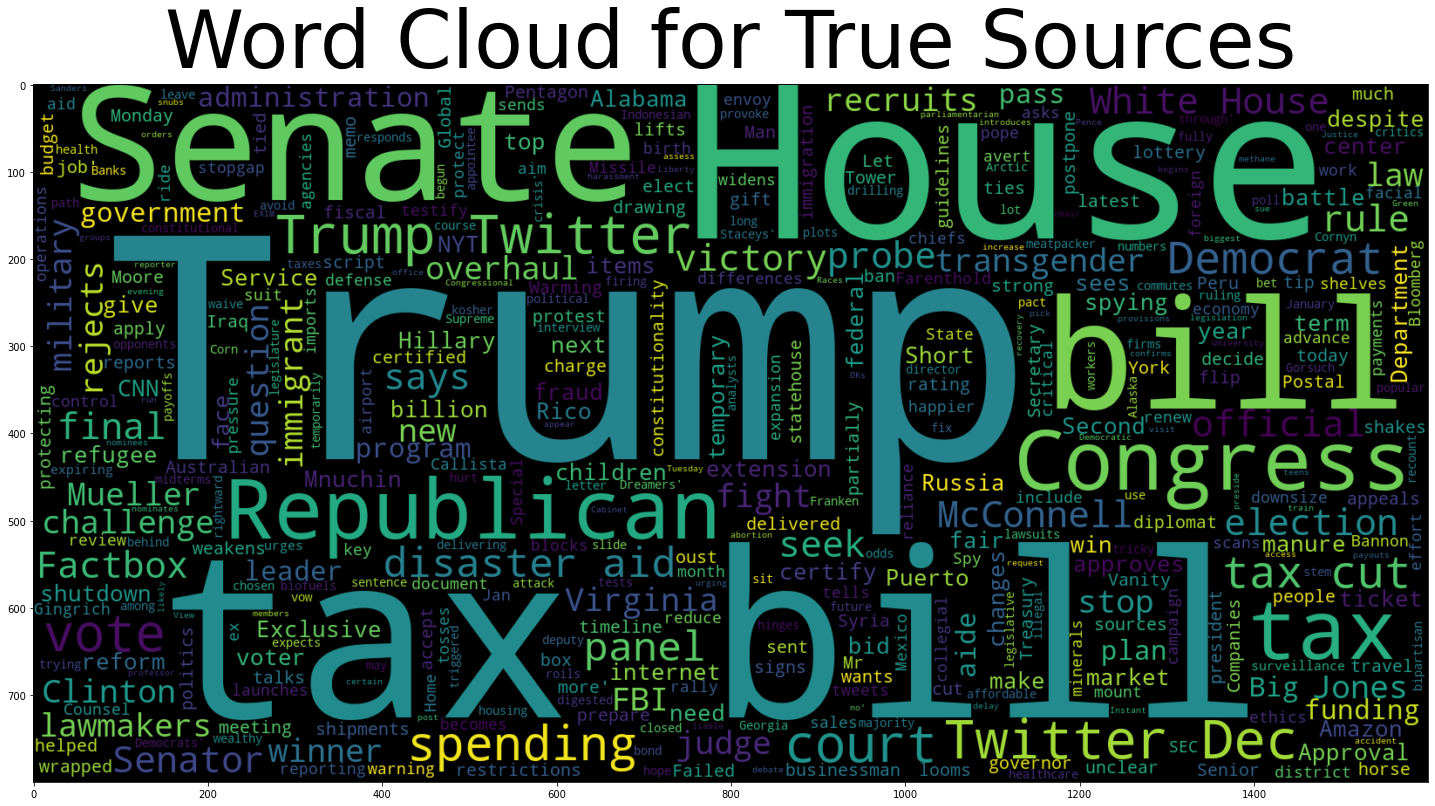

In [ ]:
plt.figure(figsize = (25,25)) # Text that is not Fake
plt.title('Word Cloud for True Sources',fontsize=80)
wc_true = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(true['title']))
plt.imshow(wc_true , interpolation = 'bilinear')

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus_false = get_corpus(false['title'])
corpus_true = get_corpus(true['title'])

In [ ]:
from collections import Counter

counter_false = Counter(corpus_false)
counter_true = Counter(corpus_true)


In [ ]:
most_common_false = counter_false.most_common(20)
most_common_false = dict(most_common_false)
most_common_false

{'(TWEETS)': 5,
 '(VIDEO)': 11,
 'Accused': 4,
 'Alabama': 5,
 'Donald': 8,
 'FBI': 4,
 'GOP': 7,
 'Gets': 6,
 'He’s': 4,
 'Losing': 4,
 'Moore': 12,
 'New': 6,
 'Obama': 5,
 'Roy': 12,
 'Senate': 6,
 'Trump': 51,
 'Trump’s': 7,
 'WATCH:': 8,
 'White': 5,
 '–': 6}

In [ ]:
most_common_true = counter_true.most_common(15)
most_common_true = dict(most_common_true)
most_common_true

{'(Dec': 9,
 'Congress': 9,
 'House': 15,
 'Republicans': 5,
 'Senate': 12,
 'Tax': 5,
 'Trump': 30,
 "Trump's": 5,
 'Twitter': 9,
 'U.S.': 24,
 'aid': 6,
 'bill': 16,
 'court': 6,
 'spending': 6,
 'tax': 23}

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Text(0.5, 1.0, 'Bigram Analysis for False Sources')

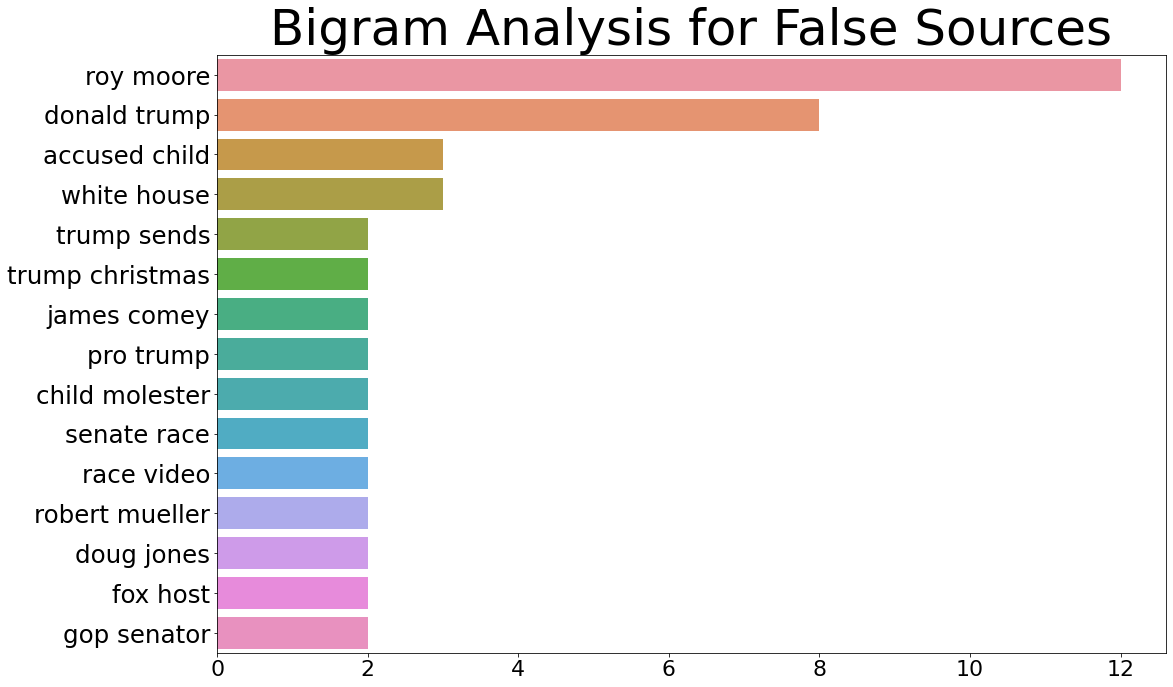

In [ ]:
plt.figure(figsize = (17,11))
most_common_bi_false = get_top_text_ngrams(false.title,15,2)
most_common_bi_false = dict(most_common_bi_false)
sns.barplot(x=list(most_common_bi_false.values()),y=list(most_common_bi_false.keys()))
plt.xticks(fontsize=22)
plt.yticks(fontsize=24.5)
plt.title('Bigram Analysis for False Sources', fontsize=50)

Text(0.5, 1.0, 'Trigram Analysis for False Sources')

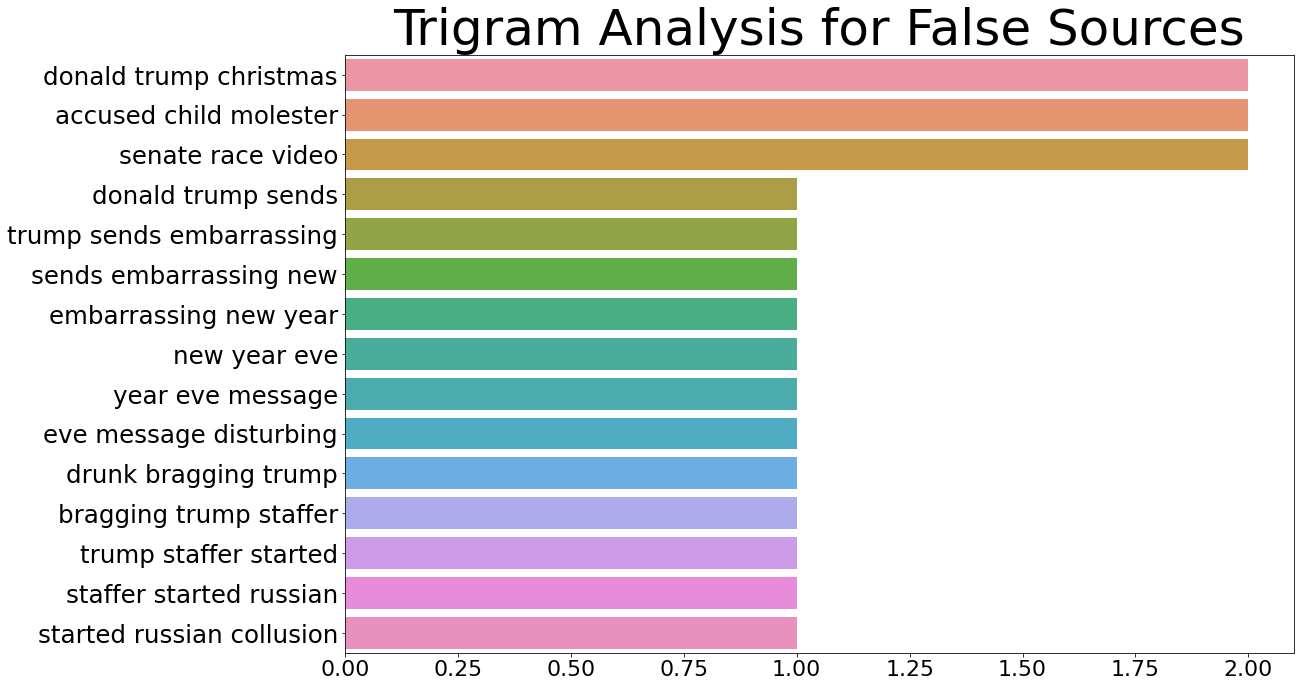

In [ ]:
plt.figure(figsize = (17,11))
most_common_tri_false = get_top_text_ngrams(false.title,15,3)
most_common_tri_false = dict(most_common_tri_false)
sns.barplot(x=list(most_common_tri_false.values()),y=list(most_common_tri_false.keys()))
plt.xticks(fontsize=22)
plt.yticks(fontsize=24.5)
plt.title('Trigram Analysis for False Sources', fontsize=50)

Text(0.5, 1.0, 'Four-gram Analysis for False Sources')

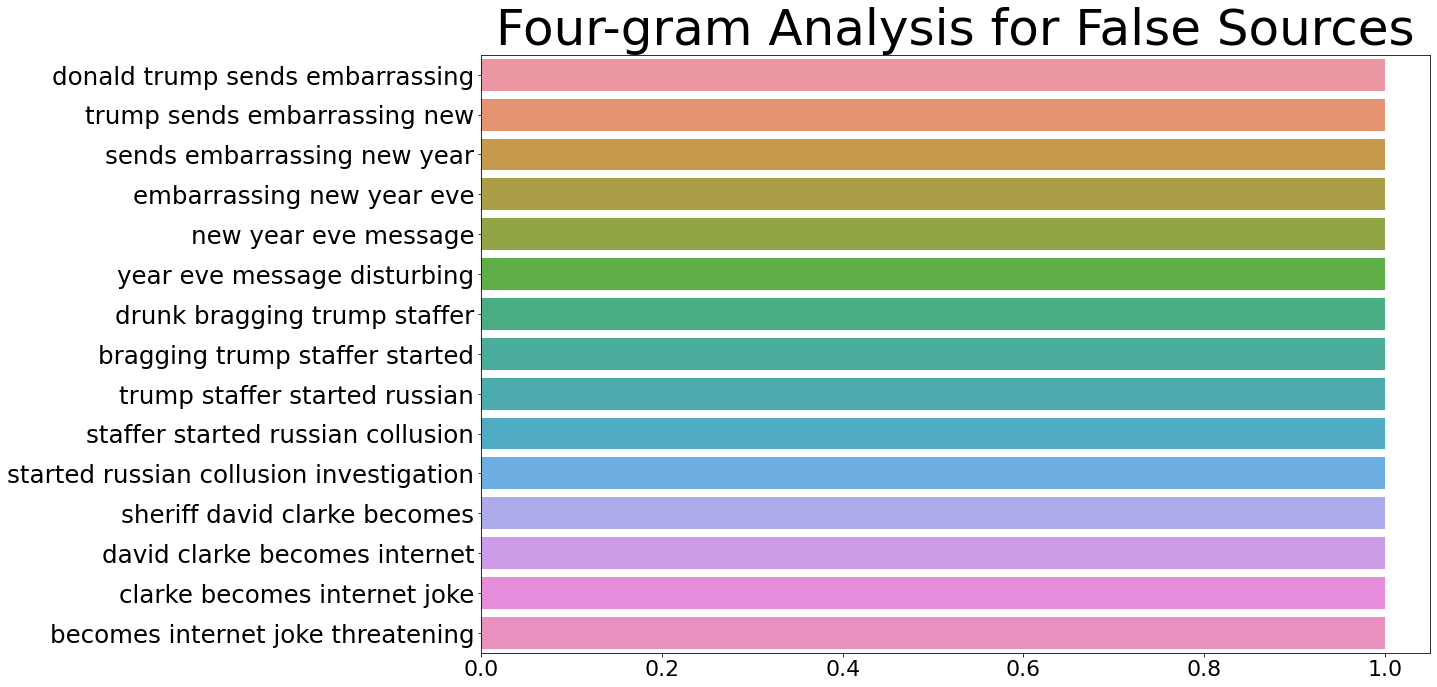

In [ ]:
plt.figure(figsize = (17,11))
most_common_fo_false = get_top_text_ngrams(false.title,15,4)
most_common_fo_false = dict(most_common_fo_false)
sns.barplot(x=list(most_common_fo_false.values()),y=list(most_common_fo_false.keys()))
plt.xticks(fontsize=22)
plt.yticks(fontsize=24.5)
plt.title('Four-gram Analysis for False Sources', fontsize=50)

Text(0.5, 1.0, 'Bigram Analysis for True Sources')

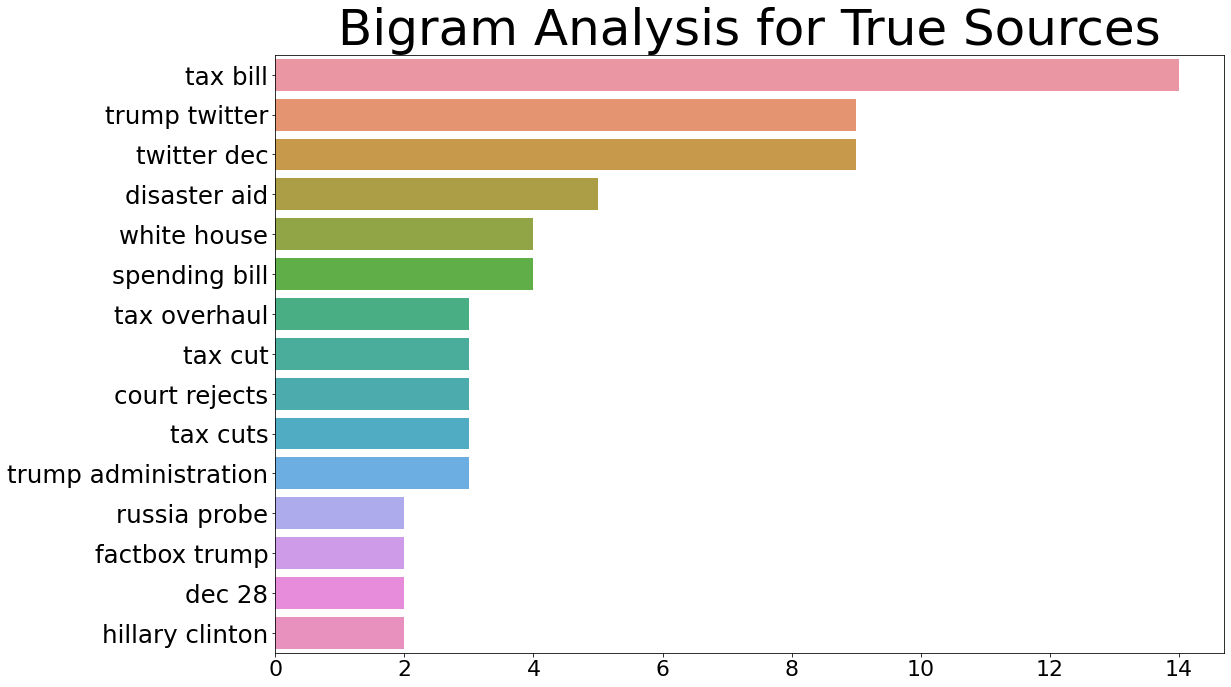

In [ ]:
plt.figure(figsize = (17,11))
most_common_bi_true = get_top_text_ngrams(true.title,15,2)
most_common_bi_true = dict(most_common_bi_true)
sns.barplot(x=list(most_common_bi_true.values()),y=list(most_common_bi_true.keys()))
plt.xticks(fontsize=22)
plt.yticks(fontsize=24.5)
plt.title('Bigram Analysis for True Sources', fontsize=50)

Text(0.5, 1.0, 'Trigram Analysis for True Sources')

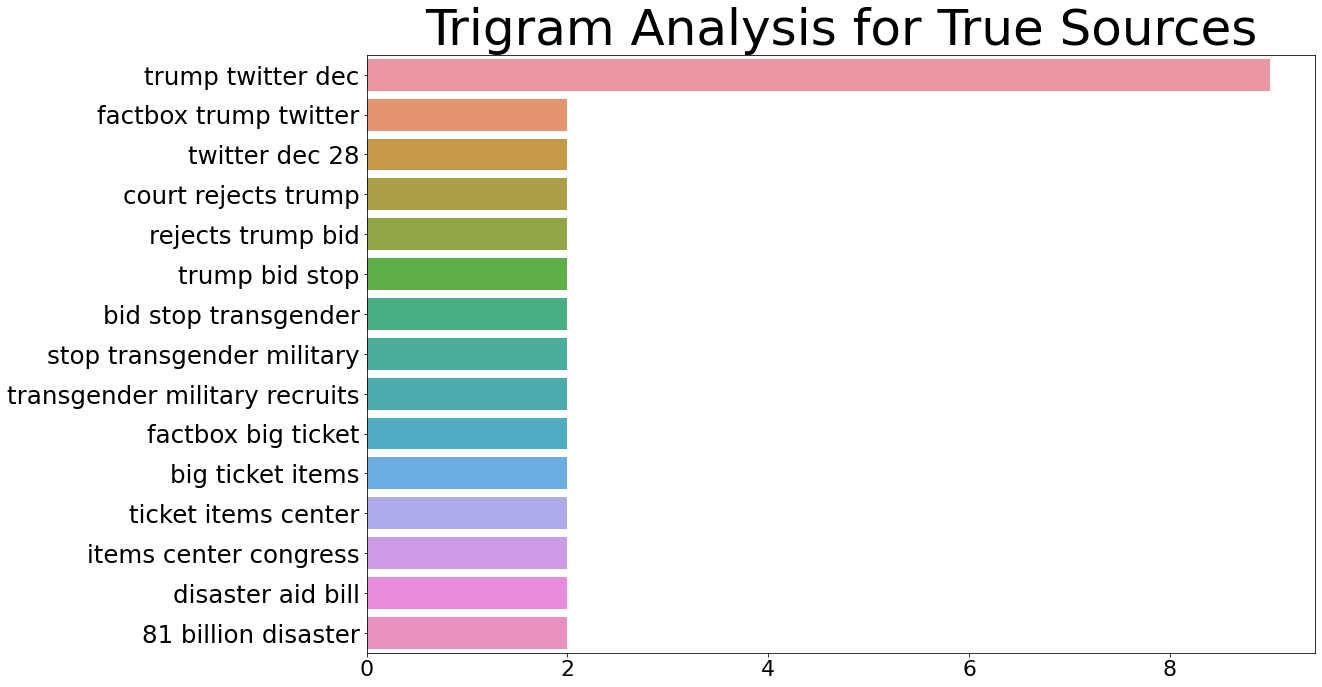

In [ ]:
plt.figure(figsize = (17,11))
most_common_tri_true = get_top_text_ngrams(true["title"],15,3)
most_common_tri_true = dict(most_common_tri_true)
sns.barplot(x=list(most_common_tri_true.values()),y=list(most_common_tri_true.keys()))
plt.xticks(fontsize=22)
plt.yticks(fontsize=24.5)
plt.title('Trigram Analysis for True Sources', fontsize=50)

Text(0.5, 1.0, 'Four-gram Analysis for True Sources')

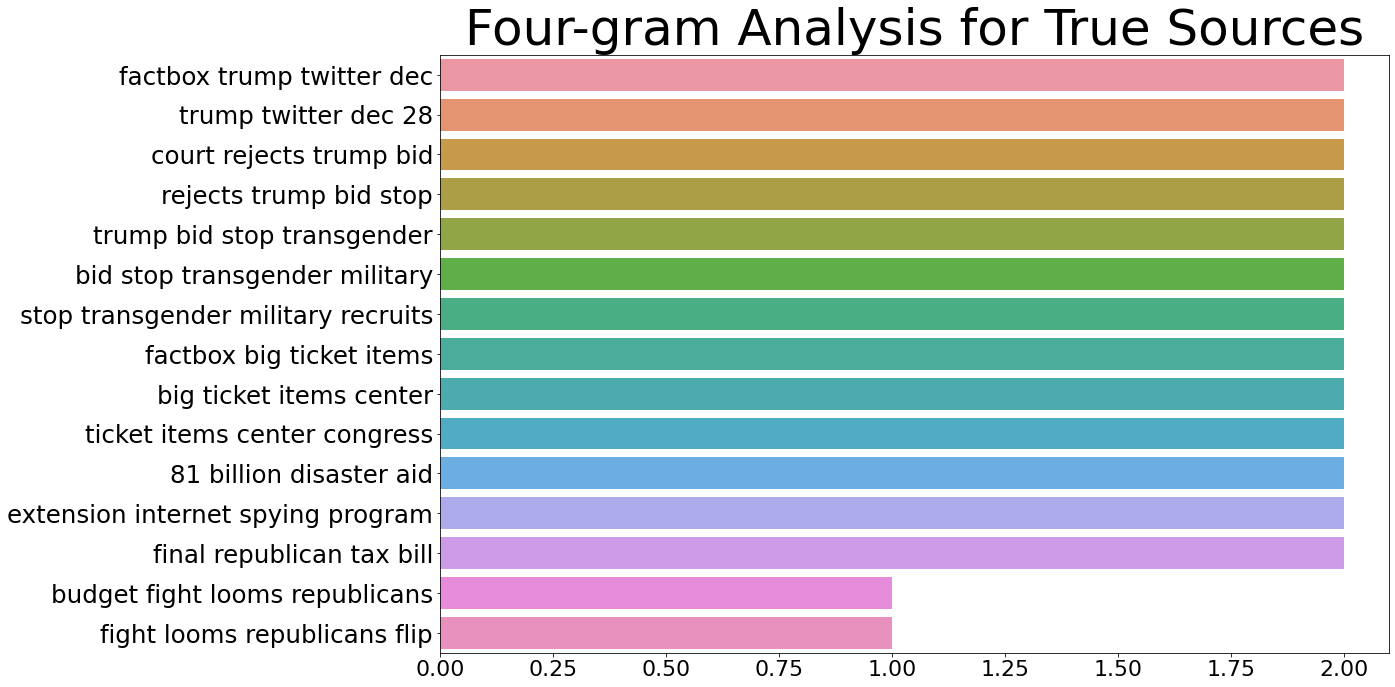

In [ ]:
plt.figure(figsize = (17,11))
most_common_fo_true = get_top_text_ngrams(true.title,15,4)
most_common_fo_true = dict(most_common_fo_true)
sns.barplot(x=list(most_common_fo_true.values()),y=list(most_common_fo_true.keys()))
plt.xticks(fontsize=22)
plt.yticks(fontsize=24.5)
plt.title('Four-gram Analysis for True Sources', fontsize=50)

In [ ]:
false_score = pd.DataFrame(data=(-1)*np.ones(len(false)),columns=['scores'])
df_false = pd.concat([false, false_score], axis=1)

df_false

title  ... scores
0   Donald Trump Sends Embarrassing New Year’s Eve...  ...   -1.0
1   Drunk Bragging Trump Staffer Started Russian C...  ...   -1.0
2   Sheriff David Clarke Becomes Internet Joke Thr...  ...   -1.0
3   Trump Obsessed Even Obama’s Name Coded Website...  ...   -1.0
4   Pope Francis Called Donald Trump Christmas Speech  ...   -1.0
..                                                ...  ...    ...
94  WATCH: Delusional Trump Fans Lash Fox Host Rep...  ...   -1.0
95  Roy Moore Supporting Republican LOSES Called E...  ...   -1.0
96  Story Trump Told Press Obama Air Force One NEV...  ...   -1.0
97  4-Year Old Tweet Donald Trump Shows Us He’s LE...  ...   -1.0
98  OOPS: Trump Judicial Nominee Didn’t Tell Congr...  ...   -1.0

[99 rows x 6 columns]

In [ ]:
true_score = pd.DataFrame(data=(1)*np.ones(len(false)),columns=['scores'])
df_true =pd.concat([true, true_score], axis=1)

df_true

title  ... scores
0   U.S. budget fight looms, Republicans flip fisc...  ...    1.0
1   U.S. military accept transgender recruits Mond...  ...    1.0
2   Senior U.S. Republican senator: 'Let Mr. Muell...  ...    1.0
3   FBI Russia probe helped Australian diplomat ti...  ...    1.0
4   Trump wants Postal Service charge 'much more' ...  ...    1.0
..                                                ...  ...    ...
94  House plan would increase Trump's disaster aid...  ...    1.0
95  House panel chair introduces $81 billion disas...  ...    1.0
96  Trump nominates Liberty University professor J...  ...    1.0
97  Trump Twitter (Dec 18) Congressional Races, tr...  ...    1.0
98  Trump Cabinet officials visit Puerto Rico asse...  ...    1.0

[99 rows x 6 columns]

In [ ]:
df = pd.concat([df_false,df_true],axis=0)
df = df.sample(frac = 1) 

df

title  ... scores
79  Trump’s Favorite News Channel Tries Soothe Bat...  ...   -1.0
67  Democrat wins one vote Virginia legislative el...  ...    1.0
57  Trump Wakes Scream Black People Hurling Racial...  ...   -1.0
96  Story Trump Told Press Obama Air Force One NEV...  ...   -1.0
37  Donald Trump’s Eating Habits Could Dramaticall...  ...   -1.0
..                                                ...  ...    ...
35  Exclusive: State Department tells refugee agen...  ...    1.0
80  Congress faces tricky path avoid government sh...  ...    1.0
81  Factbox Big-ticket items center Congress fundi...  ...    1.0
69          Time Magazine Humiliates Trump Lies Award  ...   -1.0
56            Democrat Franken leave Senate January 2  ...    1.0

[198 rows x 6 columns]

In [ ]:
X = df.iloc[:,:-2].values
y = df.iloc[:,-2].values

In [ ]:
X

array([['Two Weeks Election, Trump Still Defends Accused Child Molester TAXES, Y’all',
        'Sunday morning, after what must have seemed like another interminable weekend of scrutiny, terror, and being made to look like a fool, Donald Trump returned to doing what he does best: Being an absolute garbage person. He was still recovering from the humiliation of his hilariously bad attempt at pretending TIME Magazine\xa0 offered\xa0 him their Person of the Year honorific, followed by the embarrassment of trying to troll CNN, only to see their response tweet get twice the likes and retweets of his original.So Trump had to up his game. And how could he possibly piss off more people than by pivoting back to Roy Moore, the accused pedophile running for the US Senate in Alabama?Even some of Trump s most ardent supporters have begged the Doddering Dotard to back off his support for the toxic candidate. It s hard, as you might imagine, to truly get behind a guy who s accused of molesting young 

### ***Unigram* Decision Tree w/ Confusion Matrix**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv_title = CountVectorizer(max_features=15)
mat_title = cv_title.fit_transform(X[:,0]).todense() 
mat_text = cv_title.fit_transform(X[:,1]).todense() # an narray converted using sources
mat_title = np.hstack((mat_title,mat_text)) # puting converted titles and sources together horrizontally


In [ ]:
mat_title

matrix([[ 0,  0,  0, ..., 10,  1,  6],
        [ 0,  0,  0, ...,  3,  2,  5],
        [ 0,  0,  0, ...,  8,  4,  5],
        ...,
        [ 0,  1,  0, ...,  1,  1,  3],
        [ 0,  0,  0, ...,  9,  3,  1],
        [ 0,  0,  0, ...,  0,  0,  0]])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mat_title,y, test_size=0.25, random_state=0)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier_dtr = DecisionTreeClassifier(criterion='entropy')
classifier_dtr.fit(X_train, y_train)
y_pred_dtr = classifier_dtr.predict(X_test)

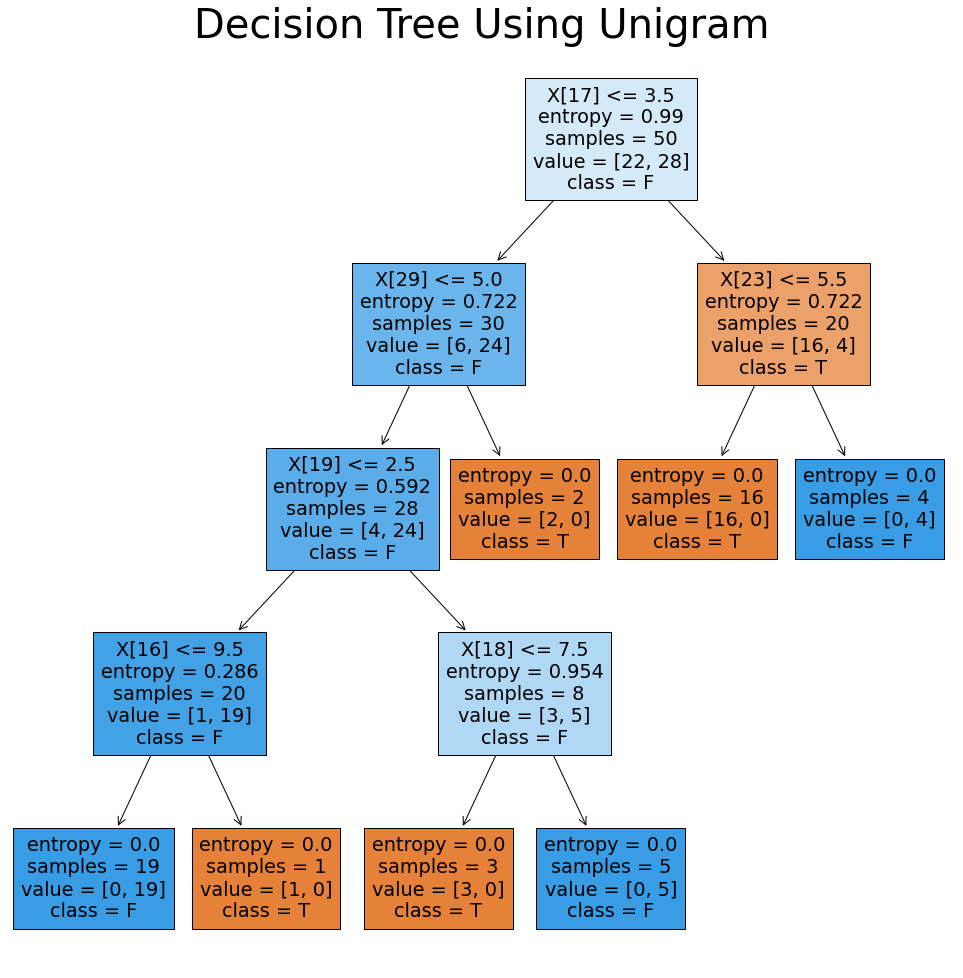

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(17,17))
clf = DecisionTreeClassifier(criterion='entropy').fit(X_test,y_pred_dtr)
plot_tree(clf,class_names=["T","F"], filled=True)
plt.title('Decision Tree Using Unigram', fontsize=40)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_dtr)

Text(0.5, 1.0, 'Confusion Matrix, Unigram')

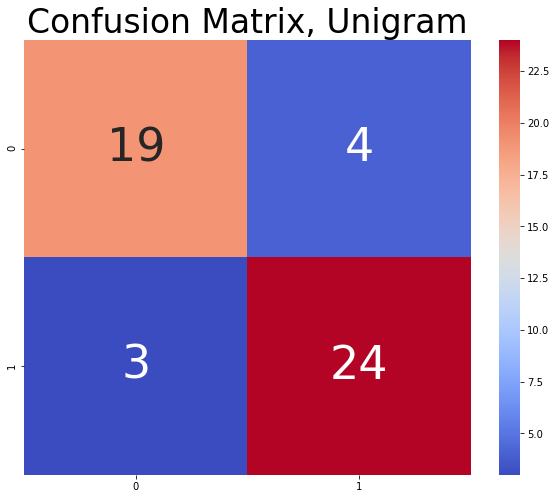

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(cm,cmap='coolwarm',annot=True,annot_kws={'size':46})
plt.title('Confusion Matrix, Unigram',fontsize=33)

In [ ]:
clf.score(X_test,y_test)

0.86

In [ ]:
from sklearn.model_selection import cross_val_score

k =4

scores = cross_val_score(classifier_dtr, mat_title, y, cv=k)

scores

array([0.84      , 0.86      , 0.79591837, 0.83673469])

In [ ]:
average_scores = np.mean(scores)
std_scores = np.std(scores)
uncertainty = (2*std_scores)/(np.sqrt(k))

print('The cross validated accuracy of the unigram model w/ uncertainty is',average_scores,'+ or -',uncertainty)

The cross validated accuracy of the unigram model w/ uncertainty is 0.8331632653061225 + or - 0.023274926403400613


### ***Bigram* Decision Tree w/ Confusion Matrix**

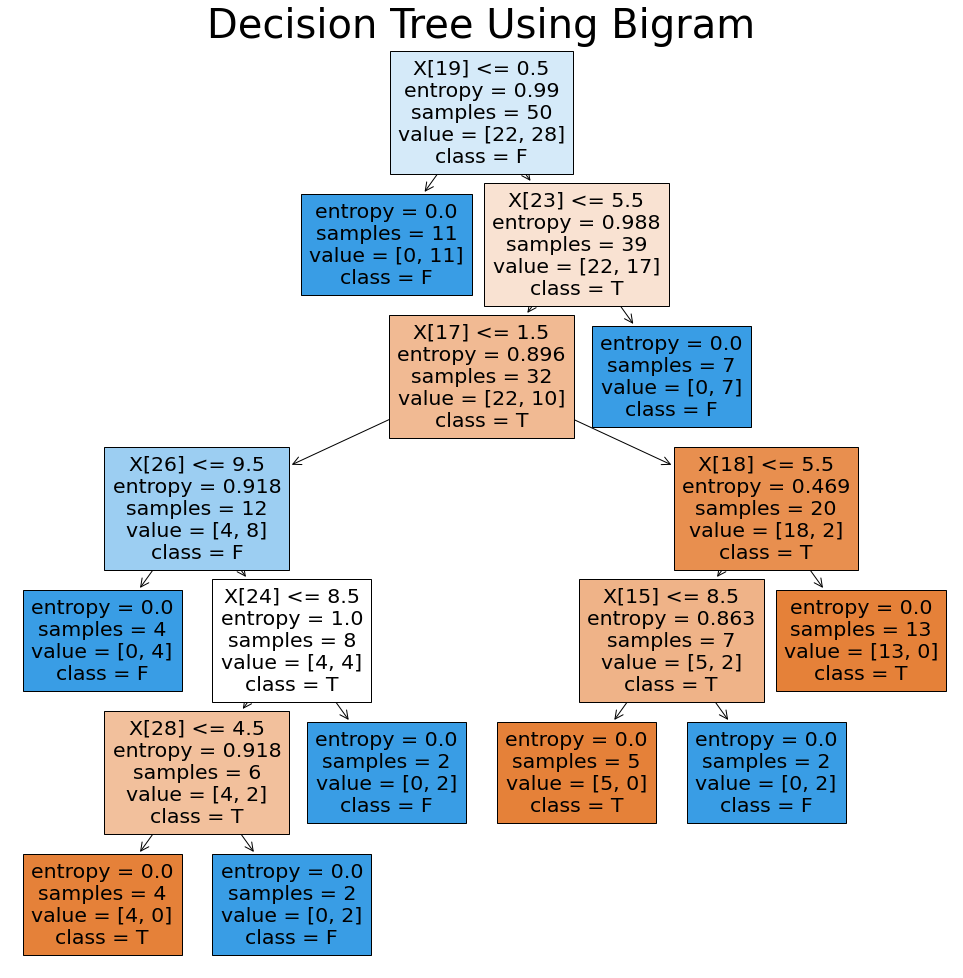

In [ ]:
#bigram decision tree

bi_cv_title = CountVectorizer(ngram_range=(2,2),max_features=15)

bi_mat_title = bi_cv_title.fit_transform(X[:,0]).todense() # an narray converted using titles
bi_mat_text = cv_title.fit_transform(X[:,1]).todense() # an array converted using sources
bi_mat_title = np.hstack((bi_mat_title,bi_mat_text)) # puting converted titles and sources together horrizontally

X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(bi_mat_title,y, 
                                                                test_size=0.25, 
                                                                random_state=0)
classifier_dtr_bi = DecisionTreeClassifier(criterion='entropy')
classifier_dtr_bi.fit(X_train_bi, y_train_bi)
y_pred_dtr_bi = classifier_dtr_bi.predict(X_test_bi)

plt.figure(figsize=(17,17))
clf_bi = DecisionTreeClassifier(criterion='entropy').fit(X_test_bi,y_pred_dtr_bi)
plot_tree(clf_bi,class_names=["T","F"], filled=True)
plt.title('Decision Tree Using Bigram', fontsize=40)
plt.show()

Text(0.5, 1.0, 'Confusion Matrix, Bigram')

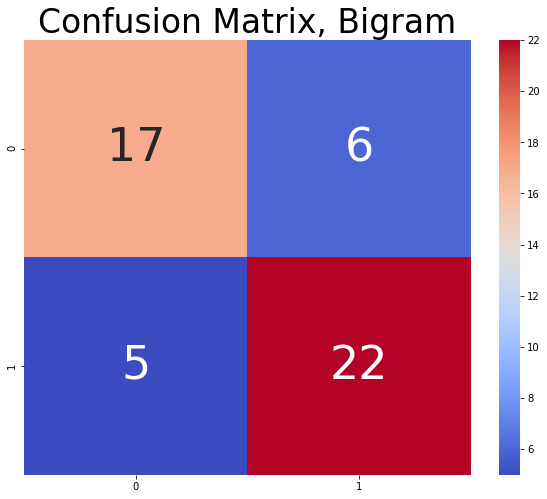

In [ ]:
cm_bi = confusion_matrix(y_test_bi, y_pred_dtr_bi)

plt.figure(figsize=(10,8))
sns.heatmap(cm_bi,cmap='coolwarm',annot=True,annot_kws={'size':46})
plt.title('Confusion Matrix, Bigram',fontsize=33)

In [ ]:
clf_bi.score(X_test_bi,y_test_bi)

0.78

In [ ]:
from sklearn.model_selection import cross_val_score

scores_bi = cross_val_score(classifier_dtr, bi_mat_title, y, cv=4)

scores_bi

array([0.86      , 0.86      , 0.85714286, 0.83673469])

In [ ]:
bi_average_scores = np.mean(scores_bi)
bi_std_scores = np.std(scores_bi)
bi_uncertainty = (2*bi_std_scores)/(np.sqrt(k))

print('The cross validated accuracy of the bigram model w/ uncertainty is',bi_average_scores,'+ or -',bi_uncertainty)

The cross validated accuracy of the bigram model w/ uncertainty is 0.8534693877551021 + or - 0.009731933891890884


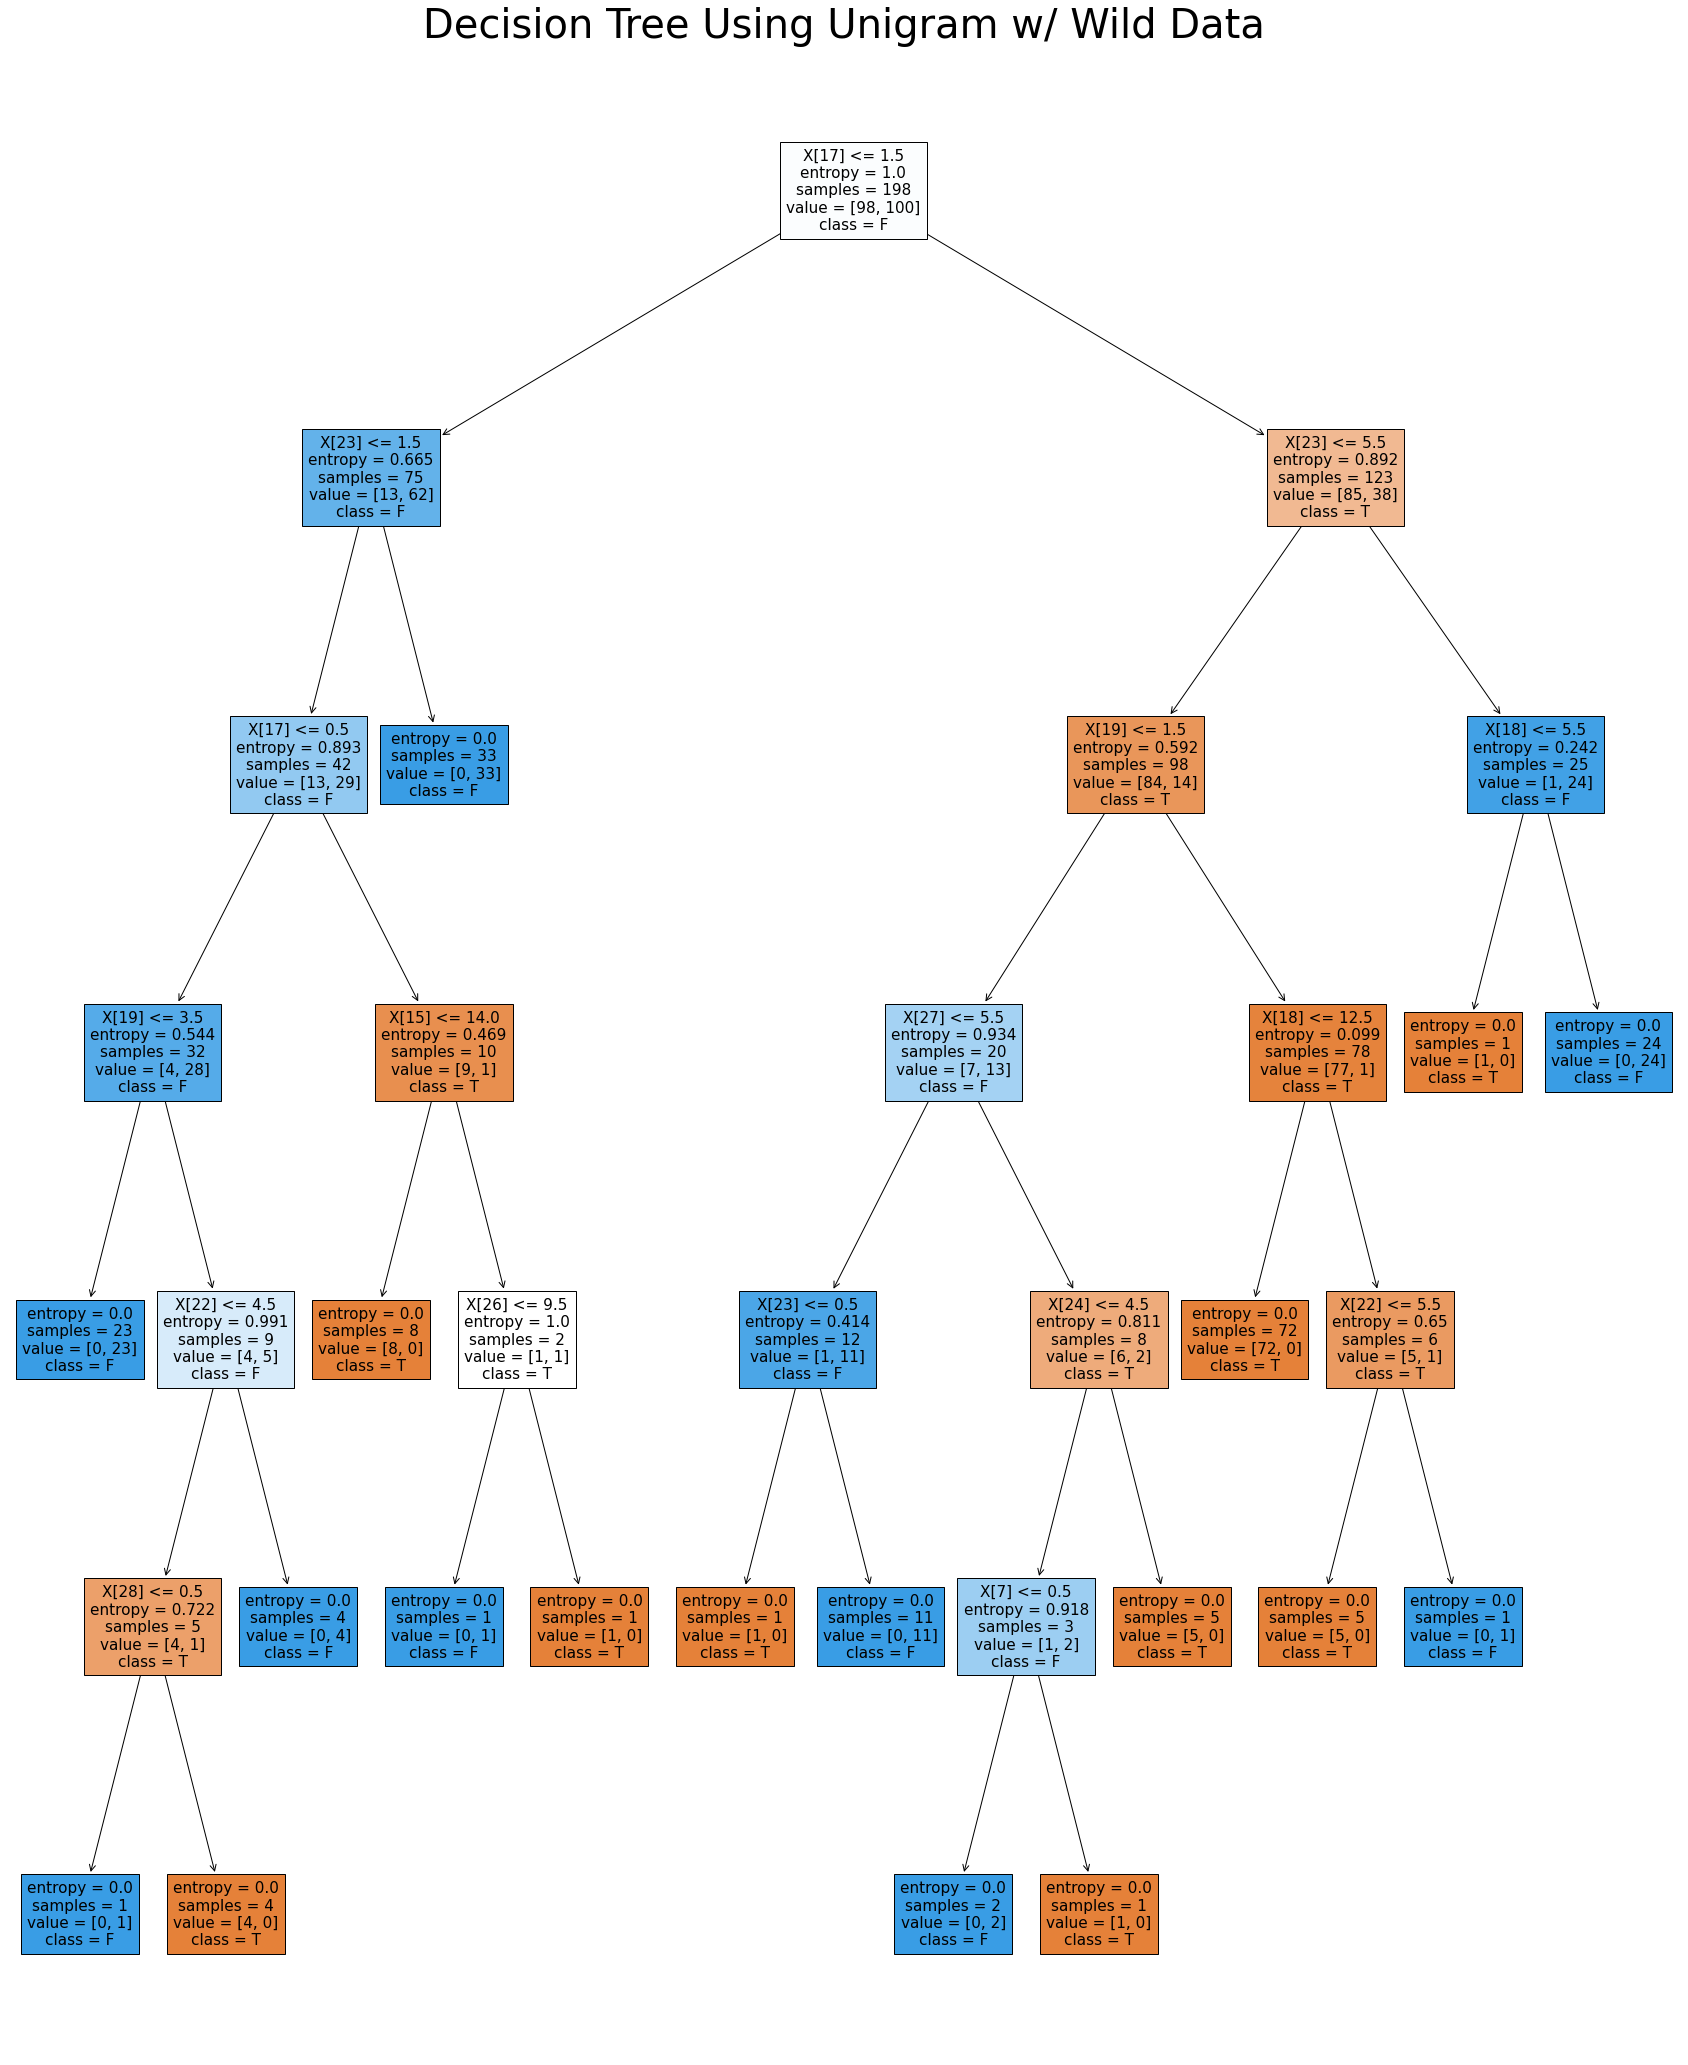

In [ ]:
y_vali_dtr = classifier_dtr.predict(mat_title)

plt.figure(figsize=(30,37))
clf_vali = DecisionTreeClassifier(criterion='entropy').fit(mat_title,y_vali_dtr)
plot_tree(clf_vali,class_names=["T","F"], filled=True)
plt.title('Decision Tree Using Unigram w/ Wild Data', fontsize=40)
plt.show()

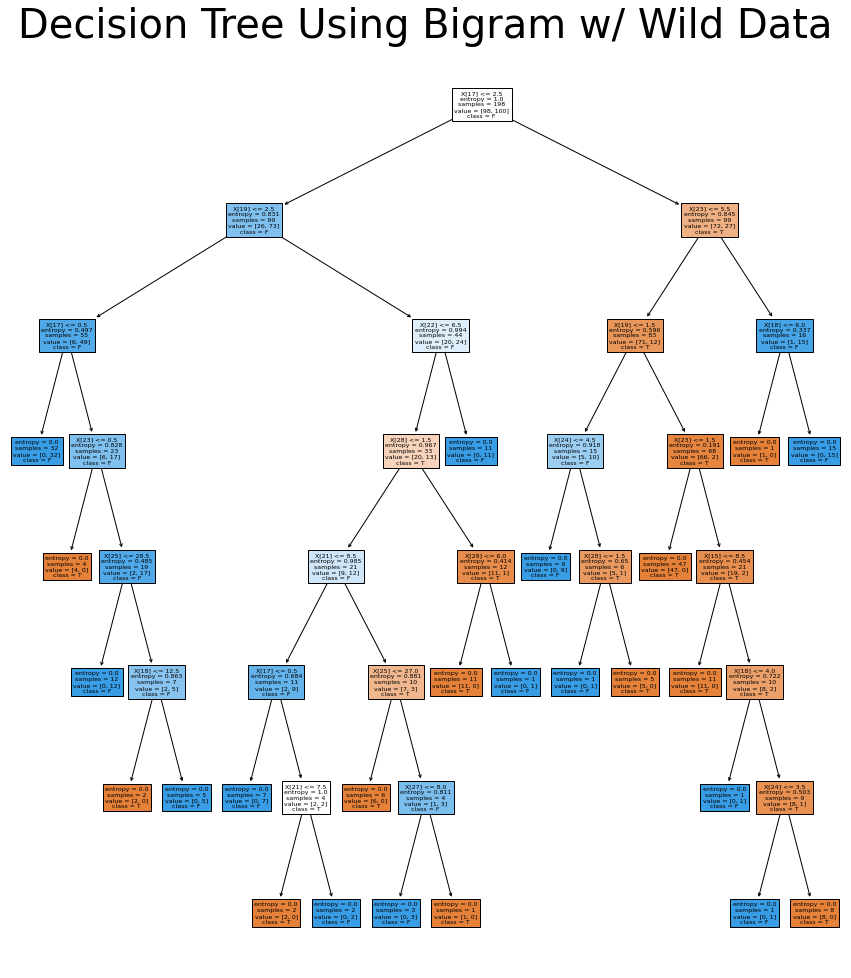

In [ ]:
y_vali_dtr_bi = classifier_dtr_bi.predict(bi_mat_title)

plt.figure(figsize=(15,17))
clf_vali_bi = DecisionTreeClassifier(criterion='entropy').fit(bi_mat_title,y_vali_dtr_bi)
plot_tree(clf_vali_bi,class_names=["T","F"], filled=True)
plt.title('Decision Tree Using Bigram w/ Wild Data', fontsize=40)
plt.show()

In [ ]:
df_vali = pd.read_excel('/content/drive/My Drive/Colab Notebooks/sample.xlsx')
df_vali['title']=df_vali['title'].apply(denoise_text)
df_vali['text']=df_vali['text'].apply(denoise_text)

df_vali

title  ... Category
0  RUPAUL CLAIMS TRUMP TOUCHED INAPPROPRIATELY 1990S  ...        F
1  Pennsylvania Supreme Court rules Trump campaig...  ...        T

[2 rows x 3 columns]

In [ ]:
X_vali = df_vali.iloc[:,:-1].values

vali_title = cv_title.fit_transform(X_vali[:,0]).todense()
vali_text = cv_title.fit_transform(X_vali[:,1]).todense()

vali_data = np.hstack((vali_title,vali_text))

y_vali_dtr = classifier_dtr.predict(vali_data)

print(y_vali_dtr)
print(average_scores,'+ or -',uncertainty)


['T' 'F']
0.8331632653061225 + or - 0.023274926403400613


In [ ]:
vali_title_bi = bi_cv_title.fit_transform(X_vali[:,0]).todense()
vali_text_bi = bi_cv_title.fit_transform(X_vali[:,1]).todense()

vali_data_bi = np.hstack((vali_title_bi,vali_text_bi))

y_vali_dtr_bi = classifier_dtr_bi.predict(vali_data_bi)

print(y_vali_dtr_bi)

print(bi_average_scores,'+ or -',bi_uncertainty)

['T' 'T']
0.8534693877551021 + or - 0.009731933891890884
